# Summary plots and tables

## Imports

Note: you'll to use scipy>=1.4.0, which is the first release that includes the beta-binomial distribution.
See https://github.com/scipy/scipy/pull/10876

In [1]:
import io
import os

# gwpy hijacks Matplotlib's default axes class.
# Take it back and restore default style.
import matplotlib
import gwpy
matplotlib.projections.register_projection(matplotlib.axes.Axes)
matplotlib.rcdefaults()

from astropy.table import join, Table, vstack
from astropy import units as u
from astropy.cosmology import default_cosmology
from matplotlib import pyplot as plt
import gwpy.table  # to read ligolw documents as Astropy tables
from IPython.display import Markdown
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import find_injection_moc
import numpy as np
from scipy import integrate
from scipy import optimize
from scipy import special
from scipy import stats
from scikits import bootstrap
import seaborn
from tqdm.auto import tqdm

## Common functions

In [2]:
def betabinom_k_n(k, n):
    return stats.betabinom(n, k + 1, n - k + 1)


@np.vectorize
def poisson_lognormal_rate_quantiles(p, mu, sigma):
    """Find the quantiles of a Poisson distribution with
    a log-normal prior on its rate.

    Parameters
    ----------
    p : float
        The quantiles at which to find the number of counts.
    mu : float
        The mean of the log of the rate.
    sigma : float
        The standard deviation of the log of the rate.

    Returns
    -------
    k : float
        The number of events.

    Notes
    -----
    This algorithm treats the Poisson count k as a continuous
    real variable so that it can use the Newton-like scipy.optimize.root_scalar
    root finding/polishing algorithms.
    """
    # Determine the equation to solve:
    #   for p < 0.5, solve       log(cdf(k)) = log(p)
    #     otherwise, solve   log(1 - cdf(k)) = log(1 - p)
    if p < 0.5:
        logp = np.log(p)
        cdf_func = special.gammaincc
        sgn = 1
    else:
        logp = np.log1p(-p)
        cdf_func = special.gammainc
        sgn = -1

    # Rate prior
    lognorm_pdf = stats.lognorm(s=sigma, scale=np.exp(mu)).pdf

    # Mode of prior, which will help us get a good initial guess
    # for root finding.
    lognorm_mode = np.exp(mu - sigma**2)
    lognorm_median = np.exp(mu)
    lognorm_mean = np.exp(mu + sigma**2/2)


    # Function and function derivative for ppf root finding.
    def ppf_func(k):

        def rhs(_, lam):
            prior = lognorm_pdf(lam)
            # Note: the Poisson pdf and cdf are written out here explicitly
            # because scipy.stats.poisson.pdf() and scipy.stats.poisson.cdf()
            # do not accept non-integer values of k.
            poisson_pdf = np.exp(special.xlogy(k, lam) - special.gammaln(k + 1) - lam)
            poisson_cdf = cdf_func(k + 1, lam)
            return poisson_pdf * prior, poisson_cdf * prior

        # Marginalize over lambda.
        #
        # Note that we use scipy.integrate.odeint instead
        # of scipy.integrate.quad because it is important for the stability of
        # root_scalar below that we calculate the pdf and the cdf at the same time,
        # using the same exact quadrature rule.
        *_, (pdf, cdf) = integrate.odeint(rhs, [0, 0], np.sort([0, 1, np.inf]))

        return sgn * (np.log(cdf) - logp), pdf / cdf

    # It can happen that there is no root because the probability of
    # 0 events is greater than or equal to p.
    if ppf_func(0)[0] >= 0:
        return 0

    result = optimize.root_scalar(ppf_func, fprime=True,
                                  x0=stats.poisson(lognorm_mode).ppf(p))
    return result.root

## Settings

In [3]:
alpha = 0.9  # Confidence band for histograms
run_dirs = ['O3_HLV', 'O3_HLVK', 'O4_HLVK']
run_names = [run_dir.replace('_', '/') for run_dir in run_dirs]
pops = ['BNS', 'NSBH', 'BBH']  # Populations
fieldnames = ['area(90)', 'vol(90)', 'distance']
fieldlabels = [r'90% credible area (deg$^2$)',
               r'90% credible comoving volume (10$^3$ Mpc$^3$)',
               'Luminosity distance (Mpc)']

In [4]:
cosmo = default_cosmology.get_cosmology_from_string('Planck15')

## Statistics for selected O2 events

In [5]:
events = ['GW170818', 'GW170817']
event_values = []
for event in tqdm(events):
    # url = 'https://dcc.ligo.org/LIGO-P1800381/public/{}_skymap.fits.gz'.format(event)
    filename = 'historical/{}_skymap.fits'.format(event)
    skymap = read_sky_map(filename, moc=True)
    result = find_injection_moc(skymap, contours=[0.9], cosmology=True)
    event_values.append([result.contour_areas[0], 1e-3 * result.contour_vols[0], skymap.meta['distmean']])

        Use ligo.skymap.postprocess.crossmatch.crossmatch instead. [warnings]


## Fiducial rates in Gpc$^{-3}$ yr$^{-1}$

From Word document received from Marica...

In [6]:
# Lower 5% and upper 95% quantiles of log normal distribution (are they?)
rates_table = Table(
    [
        {'population': 'BNS', 'lower': 110.00, 'upper': 3840.00},
        {'population': 'NSBH', 'lower': 0.60, 'upper': 1000.00},
        {'population': 'BBH', 'lower': 25.00, 'upper': 109.00}
    ]
)

standard_90pct_interval, = np.diff(stats.norm.interval(0.9))
rates_table['mu'] = 0.5 * (np.log(rates_table['lower']) + np.log(rates_table['upper']))
rates_table['sigma'] = (np.log(rates_table['upper']) - np.log(rates_table['lower'])) / standard_90pct_interval
rates_table

lower,population,upper,mu,sigma
float64,str4,float64,float64,float64
110.0,BNS,3840.0,6.476854005687095,1.079958490401946
0.6,NSBH,1000.0,3.198464827608073,2.2550884714579515
25.0,BBH,109.0,3.9551118535486722,0.44759972353588173


In [7]:
fiducial_log_rates = np.asarray(rates_table['mu'])
fiducial_log_rate_errs = np.asarray(rates_table['sigma'])

## Load all data sets

In [8]:
tables = {}
with tqdm(total=len(run_dirs) * len(pops)) as progress:
    for run_name, run_dir in zip(run_names, run_dirs):
        for pop in pops:
            path = os.path.join('runs', run_dir, pop.lower() + '_astro')
            allsky = Table.read(os.path.join(path, 'allsky.dat'), format='ascii.fast_tab')
            injections = Table.read(os.path.join(path, 'injections.dat'), format='ascii.fast_tab')
            allsky['event_id'] = [int(_.split(':')[-1]) for _ in allsky.columns.pop('coinc_event_id')]
            injections['event_id'] = [int(_.split(':')[-1]) for _ in injections.columns.pop('simulation_id')]
            table = join(allsky, injections)

            # Convert from Mpc^3 to 10^3 Mpc^3
            for colname in ['searched_vol', 'vol(20)', 'vol(50)', 'vol(90)']:
                table[colname] *= 1e-3

            # Get simulated rate from LIGO-LW process table
            process_table = Table.read(os.path.join(path, 'events.xml'),
                                       format='ligolw', tablename='process')
            table.meta['rate'] = u.Quantity(process_table[0]['comment'])

            tables.setdefault(run_name, {})[pop] = table
            del allsky, injections, table, process_table
            progress.update()

## Cumulative histograms

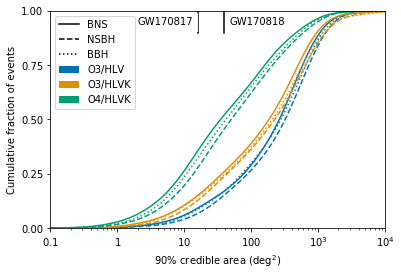

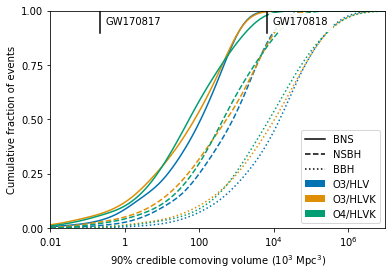

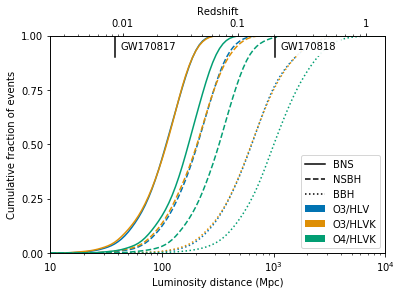

In [9]:
axs = [plt.subplots()[1] for _ in range(len(fieldnames))]
colors = seaborn.color_palette('colorblind', len(tables))
linestyles = ['-', '--', ':']

for ax, fieldlabel in zip(axs, fieldlabels):
    ax.set_xlabel(fieldlabel)

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.50, 0.75, 1])
    ax.set_ylabel('Cumulative fraction of events')
    ax.legend(
        [plt.Line2D([], [], linestyle=linestyle, color='black') for linestyle in linestyles] +
        [plt.Rectangle((0, 0), 0, 0, facecolor=color) for color in colors],
        pops + run_names)

axs[0].set_xlim(1e-1, 1e4)
axs[1].set_xlim(1e-2, 1e7)
axs[2].set_xlim(1e1, 1e4)

ax = axs[2]
zax = ax.twiny()
zax.set_xlim(*ax.get_xlim())
zax.set_xscale(ax.get_xscale())

zax.minorticks_off()
n = np.arange(2, 10)
z = np.concatenate([0.001 * n, 0.01 * n, 0.1 * n, n])
minor = cosmo.luminosity_distance(z).to_value(u.Mpc)
minor = minor[minor > ax.get_xlim()[0]]
minor = minor[minor < ax.get_xlim()[1]]
zax.set_xticks(minor, minor=True)
zax.set_xticklabels([], minor=True)

z = [0.01, 0.1, 1]
zax.set_xticks(cosmo.luminosity_distance(z).to_value(u.Mpc))
zax.set_xticklabels([str(_) for _ in z])
zax.set_xlabel('Redshift')

for irun, (run_name, tables1) in enumerate(tables.items()):
    for ipop, (pop, table) in enumerate(tables1.items()):
        for ifield, fieldname in enumerate(fieldnames):
            data = table[fieldname]
            data = data[np.isfinite(data)]
            ax = axs[ifield]
            t = np.geomspace(*ax.get_xlim(), 100)
            kde = stats.gaussian_kde(np.asarray(np.log(data)))
            (std,), = np.sqrt(kde.covariance)
            y = stats.norm(kde.dataset.ravel(), std).cdf(np.log(t)[:, np.newaxis]).mean(1)
            ax.plot(t, y, color=colors[irun], linestyle=linestyles[ipop])

for ax, value in zip(axs, event_values[0]):
    ax.axvline(value, ymin=0.9, color='black')
    ax.annotate(events[0], (value, 0.95), (5.5, 0), textcoords='offset points', va='center', ha='left', backgroundcolor=(1, 1, 1, 0.9))

for ax, value in zip(axs, event_values[1]):
    ax.axvline(value, ymin=0.9, color='black')
    ax.annotate(events[1], (value, 0.95), ((-5.5 if ax is axs[0] else 5.5), 0), textcoords='offset points', va='center', ha=('right' if ax is axs[0] else 'left'), backgroundcolor=(1, 1, 1, 0.9))

for ax, fieldname in zip(axs, fieldnames):
    ax.figure.savefig(fieldname + '.pdf')
    ax.figure.savefig(fieldname + '.svg')

## Tabulated statistics

In [10]:
np.random.seed(150914)
statfunc = np.nanmedian
f = io.StringIO()
for fieldname, fieldlabel in zip(fieldnames + ['volume', 'rate'], fieldlabels + ['Sensitive volume (Gpc$^3$)', 'Annual number of detections']):
    print('+-----------+-----------+---------------+---------------+---------------+')
    print('| {:69s} |'.format(fieldlabel))
    print('<table>', file=f)
    print('<caption>', fieldlabel, '</caption>', file=f)
    print('<thead>', file=f)
    print('<tr>', file=f)
    print('<th>', 'Run', '</th>', file=f)
    for pop in pops:
        print('<th>', pop, '</th>', file=f)
    print('</tr>', file=f)
    print('</thead>', file=f)
    print('<tbody>', file=f)
    for irun, (run, tables1) in enumerate(tables.items()):
        print('<tr>', file=f)
        print('<th>', run, '</th>', file=f)

        results = {}
        for ipop, (pop, table) in enumerate(tables1.items()):
            rate = table.meta['rate'].to_value(u.Gpc**-3 * u.yr**-1)
            fiducial_log_rate = fiducial_log_rates[ipop]
            fiducial_log_rate_err = fiducial_log_rate_errs[ipop]
            mu = fiducial_log_rate + np.log(len(table) / rate)
            sigma = fiducial_log_rate_err

            quantiles = [0.05, 0.5, 0.95]
            if fieldname == 'volume':
                # Hardcoded 100000 injections (FIXME: can get from process_params)
                lo, mid, hi = betabinom_k_n(len(table), 100000).ppf(quantiles) / rate
            elif fieldname == 'rate':
                lo, mid, hi = poisson_lognormal_rate_quantiles(quantiles, mu, sigma)
                lo = int(np.floor(lo))
                mid = int(np.round(mid))
                hi = int(np.ceil(hi))
            else:
                data = table[fieldname]
                lo, mid, hi = bootstrap.ci(data, statfunc, quantiles)

            if fieldname == 'rate':
                mid, hi, lo = str(mid), str(hi - mid), str(mid - lo)
            else:
                mid, hi, lo = (np.format_float_positional(
                        _, precision=2, fractional=False).rstrip('.')
                      for _ in (mid, hi - mid, mid - lo))
            mathtext = '{}^{{+{}}}_{{-{}}}'.format(mid, hi, lo)
            print('<td>${}$</td>'.format(mathtext), file=f)

            results.setdefault('lo', {})[pop] = lo
            results.setdefault('mid', {})[pop] = mid
            results.setdefault('hi', {})[pop] = hi

        print('</tr>', file=f)
        print('+-----------+-----------+---------------+---------------+---------------+')
        print('| {:9s} | {:9s} '.format(*run.split('/')) + ('| :math:`{:7s}' * 3).format(*results['mid'].values()) + '|')
        print('|           |           ' + ('| ^{:13s}' * 3).format(*('{{+{}}}'.format(_) for _ in results['hi'].values())) + '|')
        print('|           |           ' + ('| _{:13s}' * 3).format(*('{{-{}}}`'.format(_) for _ in results['lo'].values())) + '|')
    print('</tbody>', file=f)
    print('</table>', file=f)
print('+-----------+-----------+---------------+---------------+---------------+')
Markdown(f.getvalue())

+-----------+-----------+---------------+---------------+---------------+
| 90% credible area (deg$^2$)                                           |
+-----------+-----------+---------------+---------------+---------------+
| O3        | HLV       | :math:`270    | :math:`330    | :math:`280    |
|           |           | ^{+34}        | ^{+24}        | ^{+30}        |
|           |           | _{-20}`       | _{-31}`       | _{-23}`       |
+-----------+-----------+---------------+---------------+---------------+
| O3        | HLVK      | :math:`190    | :math:`240    | :math:`220    |
|           |           | ^{+36}        | ^{+37}        | ^{+33}        |
|           |           | _{-30}`       | _{-44}`       | _{-24}`       |
+-----------+-----------+---------------+---------------+---------------+
| O4        | HLVK      | :math:`33     | :math:`50     | :math:`41     |
|           |           | ^{+4.9}       | ^{+8.0}       | ^{+7.2}       |
|           |           | _{-5.3}`    

/Users/lpsinger/Library/Caches/pypoetry/virtualenvs/simulations-py3.7/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


+-----------+-----------+---------------+---------------+---------------+
| O3        | HLV       | :math:`1      | :math:`0      | :math:`17     |
|           |           | ^{+12}        | ^{+19}        | ^{+22}        |
|           |           | _{-1}`        | _{-0}`        | _{-11}`       |
+-----------+-----------+---------------+---------------+---------------+
| O3        | HLVK      | :math:`1      | :math:`0      | :math:`18     |
|           |           | ^{+12}        | ^{+19}        | ^{+22}        |
|           |           | _{-1}`        | _{-0}`        | _{-12}`       |
+-----------+-----------+---------------+---------------+---------------+
| O4        | HLVK      | :math:`10     | :math:`1      | :math:`79     |
|           |           | ^{+52}        | ^{+91}        | ^{+89}        |
|           |           | _{-10}`       | _{-1}`        | _{-44}`       |
+-----------+-----------+---------------+---------------+---------------+


<table>
<caption> 90% credible area (deg$^2$) </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$270^{+34}_{-20}$</td>
<td>$330^{+24}_{-31}$</td>
<td>$280^{+30}_{-23}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$190^{+36}_{-30}$</td>
<td>$240^{+37}_{-44}$</td>
<td>$220^{+33}_{-24}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$33^{+4.9}_{-5.3}$</td>
<td>$50^{+8.0}_{-8.4}$</td>
<td>$41^{+7.2}_{-5.7}$</td>
</tr>
</tbody>
</table>
<table>
<caption> 90% credible comoving volume (10$^3$ Mpc$^3$) </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$120^{+19}_{-24}$</td>
<td>$860^{+150}_{-150}$</td>
<td>$16000^{+2200}_{-2500}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$79^{+27}_{-19}$</td>
<td>$560^{+190}_{-160}$</td>
<td>$11000^{+2300}_{-2300}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$52^{+9.9}_{-9.1}$</td>
<td>$430^{+100}_{-78}$</td>
<td>$7700^{+1500}_{-920}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Luminosity distance (Mpc) </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$110^{+3.7}_{-4.6}$</td>
<td>$210^{+6.6}_{-8.2}$</td>
<td>$640^{+29}_{-19}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$110^{+3.8}_{-4.2}$</td>
<td>$210^{+7.7}_{-6.9}$</td>
<td>$630^{+25}_{-23}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$170^{+6.3}_{-4.8}$</td>
<td>$330^{+7.0}_{-13}$</td>
<td>$990^{+35}_{-29}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Sensitive volume (Gpc$^3$) </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$0.0033^{+0.00028}_{-0.00026}$</td>
<td>$0.02^{+0.0016}_{-0.0015}$</td>
<td>$0.34^{+0.026}_{-0.025}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$0.0034^{+0.00028}_{-0.00027}$</td>
<td>$0.020^{+0.0016}_{-0.0015}$</td>
<td>$0.35^{+0.026}_{-0.025}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$0.016^{+0.0014}_{-0.0013}$</td>
<td>$0.092^{+0.0077}_{-0.0072}$</td>
<td>$1.5^{+0.10}_{-0.096}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Annual number of detections </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$1^{+12}_{-1}$</td>
<td>$0^{+19}_{-0}$</td>
<td>$17^{+22}_{-11}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$1^{+12}_{-1}$</td>
<td>$0^{+19}_{-0}$</td>
<td>$18^{+22}_{-12}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$10^{+52}_{-10}$</td>
<td>$1^{+91}_{-1}$</td>
<td>$79^{+89}_{-44}$</td>
</tr>
</tbody>
</table>


In [11]:
np.random.seed(150914)
statfunc = np.nanmedian
f = io.StringIO()
for fieldlabel, statfunc in [
            [
                'Percentage of events with area(90) <= 5 deg2',
                lambda _: stats.percentileofscore(_['area(90)'], 5)
            ],
            [
                'Percentage of events with area(90) <= 20 deg2',
                lambda _: stats.percentileofscore(_['area(90)'], 20)
            ],
            [
                'Percentage of events with vol(90) <= 1e3 Mpc3',
                lambda _: stats.percentileofscore(_['vol(90)'], 1)
            ],
            [
                'Percentage of events with vol(90) <= 1e4 Mpc3',
                lambda _: stats.percentileofscore(_['vol(90)'], 10)
            ]
        ]:
    print('+-----------+-----------+---------------+---------------+---------------+')
    print('| {:69s} |'.format(fieldlabel))
    print('<table>', file=f)
    print('<caption>', fieldlabel, '</caption>', file=f)
    print('<thead>', file=f)
    print('<tr>', file=f)
    print('<th>', 'Run', '</th>', file=f)
    for pop in pops:
        print('<th>', pop, '</th>', file=f)
    print('</tr>', file=f)
    print('</thead>', file=f)
    print('<tbody>', file=f)
    for irun, (run, tables1) in enumerate(tables.items()):
        print('<tr>', file=f)
        print('<th>', run, '</th>', file=f)
        for ipop, (pop, table) in enumerate(tables1.items()):
            quantiles = [0.05, 0.5, 0.95]
            lo, mid, hi = bootstrap.ci(table, statfunc, quantiles)

            mid, hi, lo = (np.format_float_positional(
                    _, precision=2, fractional=False).rstrip('.')
                  for _ in (mid, hi - mid, mid - lo))
            mathtext = '{}^{{+{}}}_{{-{}}}'.format(mid, hi, lo)
            print('<td>${}$</td>'.format(mathtext), file=f)

            results.setdefault('lo', {})[pop] = lo
            results.setdefault('mid', {})[pop] = mid
            results.setdefault('hi', {})[pop] = hi

        print('</tr>', file=f)
        print('+-----------+-----------+---------------+---------------+---------------+')
        print('| {:9s} | {:9s} '.format(*run.split('/')) + ('| :math:`{:7s}' * 3).format(*results['mid'].values()) + '|')
        print('|           |           ' + ('| ^{:13s}' * 3).format(*('{{+{}}}'.format(_) for _ in results['hi'].values())) + '|')
        print('|           |           ' + ('| _{:13s}' * 3).format(*('{{-{}}}`'.format(_) for _ in results['lo'].values())) + '|')
    print('</tbody>', file=f)
    print('</table>', file=f)
print('+-----------+-----------+---------------+---------------+---------------+')
Markdown(f.getvalue())

+-----------+-----------+---------------+---------------+---------------+
| Percentage of events with area(90) <= 5 deg2                          |
+-----------+-----------+---------------+---------------+---------------+
| O3        | HLV       | :math:`2.6    | :math:`1.6    | :math:`2.2    |
|           |           | ^{+1.1}       | ^{+0.82}      | ^{+0.92}      |
|           |           | _{-0.74}`     | _{-0.59}`     | _{-0.61}`     |
+-----------+-----------+---------------+---------------+---------------+
| O3        | HLVK      | :math:`4.9    | :math:`3.6    | :math:`4.8    |
|           |           | ^{+1.3}       | ^{+1.2}       | ^{+1.2}       |
|           |           | _{-1.1}`      | _{-0.93}`     | _{-1}`        |
+-----------+-----------+---------------+---------------+---------------+
| O4        | HLVK      | :math:`14     | :math:`10     | :math:`12     |
|           |           | ^{+2.2}       | ^{+1.8}       | ^{+1.6}       |
|           |           | _{-1.9}`    

<table>
<caption> Percentage of events with area(90) <= 5 deg2 </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$2.6^{+1.1}_{-0.74}$</td>
<td>$1.6^{+0.82}_{-0.59}$</td>
<td>$2.2^{+0.92}_{-0.61}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$4.9^{+1.3}_{-1.1}$</td>
<td>$3.6^{+1.2}_{-0.93}$</td>
<td>$4.8^{+1.2}_{-1}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$14^{+2.2}_{-1.9}$</td>
<td>$10^{+1.8}_{-1.7}$</td>
<td>$12^{+1.6}_{-1.4}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Percentage of events with area(90) <= 20 deg2 </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$11^{+2}_{-1.6}$</td>
<td>$8^{+1.6}_{-1.4}$</td>
<td>$11^{+1.6}_{-1.5}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$17^{+2.3}_{-2.1}$</td>
<td>$14^{+2.1}_{-1.7}$</td>
<td>$17^{+2}_{-1.9}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$41^{+2.8}_{-2.9}$</td>
<td>$32^{+2.6}_{-2.6}$</td>
<td>$37^{+2.2}_{-2.2}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Percentage of events with vol(90) <= 1e3 Mpc3 </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$8.2^{+1.6}_{-1.5}$</td>
<td>$2.2^{+0.94}_{-0.70}$</td>
<td>$0.41^{+0.51}_{-0.20}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$11^{+1.8}_{-1.7}$</td>
<td>$4.8^{+1.3}_{-1.2}$</td>
<td>$1.2^{+0.7}_{-0.5}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$9^{+1.8}_{-1.7}$</td>
<td>$3.8^{+1.2}_{-0.96}$</td>
<td>$1.1^{+0.54}_{-0.39}$</td>
</tr>
</tbody>
</table>
<table>
<caption> Percentage of events with vol(90) <= 1e4 Mpc3 </caption>
<thead>
<tr>
<th> Run </th>
<th> BNS </th>
<th> NSBH </th>
<th> BBH </th>
</tr>
</thead>
<tbody>
<tr>
<th> O3/HLV </th>
<td>$21^{+2.3}_{-2.2}$</td>
<td>$9.6^{+1.8}_{-1.5}$</td>
<td>$1.8^{+0.82}_{-0.61}$</td>
</tr>
<tr>
<th> O3/HLVK </th>
<td>$28^{+2.5}_{-2.5}$</td>
<td>$13^{+2}_{-1.9}$</td>
<td>$3.4^{+1}_{-0.9}$</td>
</tr>
<tr>
<th> O4/HLVK </th>
<td>$28^{+2.7}_{-2.6}$</td>
<td>$10^{+1.8}_{-1.7}$</td>
<td>$3.3^{+0.93}_{-0.7}$</td>
</tr>
</tbody>
</table>
